<a href="https://colab.research.google.com/github/Luan2004/Intrusion-Detection-System-IDS-/blob/main/DA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chuẩn bị dữ liệu**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical # type: ignore
from imblearn.over_sampling import SMOTE  # Import SMOTE
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import  Input, Dense, Dropout, GRU, BatchNormalization, Activation # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.metrics import Precision, Recall # type: ignore
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

a) Tách từng loại tấn công từ file nguồn (kaggle)

In [ ]:
# Tách từng loại tấn công ra từng file
def separate(sourceFile, label, saveFile):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(sourceFile)
    # Lọc các hàng có nhãn label
    df_la = df[df[' Label'] == label]
    # Ghi dữ liệu vào file (tạo mới hoặc thêm vào file đã có)
    df_la.to_csv(saveFile, mode='w', header=True, index=False)
    print(f"{label} đã được tách")

separate("/content/drive/MyDrive/Data_source/Monday-WorkingHours.pcap_ISCX.csv", "BENIGN", "/content/Data processing/BENIGN.csv")
separate("/content/drive/MyDrive/Data_source/Tuesday-WorkingHours.pcap_ISCX.csv", "FTP-Patator", "/content/Data processing/FTP-Patator.csv")
separate("/content/drive/MyDrive/Data_source/Wednesday-workingHours.pcap_ISCX.csv", "DoS GoldenEye", "/content/Data processing/DoS GoldenEye.csv")
separate("/content/drive/MyDrive/Data_source/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", "Infiltration", "/content/Data processing/Infiltration.csv")
separate("/content/drive/MyDrive/Data_source/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", "Web Attack � Brute Force", "/content/Data processing/Web Attack � Brute Force.csv")
separate("/content/drive/MyDrive/Data_source/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", "Web Attack � XSS", "/content/Data processing/Web Attack � XSS.csv")
separate("/content/drive/MyDrive/Data_source/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", "Web Attack � Sql Injection", "/content/Data processing/Web Attack � Sql Injection.csv")
separate("/content/drive/MyDrive/Data_source/Wednesday-workingHours.pcap_ISCX.csv", "DoS slowloris", "/content/Data processing/DoS slowloris.csv")
separate("/content/drive/MyDrive/Data_source/Wednesday-workingHours.pcap_ISCX.csv", "DoS Hulk", "/content/Data processing/DoS Hulk.csv")
separate("/content/drive/MyDrive/Data_source/Wednesday-workingHours.pcap_ISCX.csv", "DoS Slowhttptest", "/content/Data processing/DoS Slowhttptest.csv")
separate("/content/drive/MyDrive/Data_source/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", "DDoS", "/content/Data processing/DDoS.csv")
separate("/content/drive/MyDrive/Data_source/Tuesday-WorkingHours.pcap_ISCX.csv", "SSH-Patator", "/content/Data processing/SSH-Patator.csv")
separate("/content/drive/MyDrive/Data_source/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", "PortScan", "/content/Data processing/PortScan.csv")
separate("/content/drive/MyDrive/Data_source/Wednesday-workingHours.pcap_ISCX.csv", "Heartbleed", "/content/Data processing/Heartbleed.csv")
separate("/content/drive/MyDrive/Data_source/Friday-WorkingHours-Morning.pcap_ISCX.csv", "Bot", "/content/Data processing/Bot.csv")

b) Kiểm tra các giá trị Nan, Inf và Outlier trước khi xử lý

In [ ]:
# Kiểm tra số lượng Nan, Inf và outlier
def checkData(saveFile):
    df = pd.read_csv(saveFile)
    # Chỉ lấy những cột có kiểu dữ liệu số
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        nan_count = df[col].isna().sum()  # Kiểm tra số lượng Nan
        inf_count = np.isinf(df[col]).sum() # Kiểm tra số lượng Inf

        # Kiểm tra outlier dựa trên tứ vị phân IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
        veoutliers = df[(df[col] < (Q1 - 3 * IQR)) | (df[col] > (Q3 + 3 * IQR))]

        print(saveFile)
        if (nan_count>0 or inf_count>0 or len(outliers)>0):
            print(f"Cột {col}: ")
        if (nan_count>0):
            print(f"Nan: {nan_count}")
        if(inf_count>0):
            print(f"Inf: {inf_count}")
        if(len(outliers)>0):
            print(f"Outlier: {len(outliers)}")
            print(f"Very Outlier: {len(veoutliers)}\n")

        # Vẽ boxplot để minh họa ngoại lệ
        plt.figure(figsize=(4, 3))    # Kích thước khung box
        sns.boxplot(x=df[col])        # Vẽ biểu đồ boxplot (biểu đồ hộp râu) cho cột col
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7) # Tạo đường nét dứt dọc theo trục y của boxplot
        plt.show()

# Path tập các loại tấn công
attack_types = ["/content/Data processing/BENIGN.csv", "/content/Data processing/Bot.csv",
                "/content/Data processing/DDoS.csv", "/content/Data processing/DoS GoldenEye.csv",
                "/content/Data processing/DoS Hulk.csv", "/content/Data processing/DoS slowloris.csv",
                "/content/Data processing/DoS Slowhttptest.csv", "/content/Data processing/FTP-Patator.csv",
                "/content/Data processing/Heartbleed.csv", "/content/Data processing/Infiltration.csv",
                "/content/Data processing/PortScan.csv", "/content/Data processing/SSH-Patator.csv",
                "/content/Data processing/Web Attack � Brute Force.csv", "/content/Data processing/Web Attack � Sql Injection.csv",
                "/content/Data processing/Web Attack � XSS.csv"]
for attack in attack_types:
    checkData(attack)

c) Xử lý các giá trị Nan, Inf, Outlier

In [ ]:
# Xử lý các giá trị Nan, Inf và outlier
def processing(saveFile):
    df = pd.read_csv(saveFile)

    # Chọn các cột có kiểu dữ liệu là số
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Kiểm tra số lượng giá trị NaN và inf
    nan_count = df[numerical_cols].isna().sum().sum()
    inf_count = np.isinf(df[numerical_cols]).sum().sum()

    print(saveFile)
    # Kiểm tra tỷ lệ giá trị lỗi
    length = len(df)   # Tổng số mẫu
    invalid_ratio = (nan_count + inf_count) / length
    # Nếu số lượng Nan và Inf không vượt quá 5% bộ dữ liệu thì xóa
    if invalid_ratio < 0.05:
        print(f"Tổng số giá trị lỗi: {nan_count + inf_count} ({invalid_ratio*100:.2f}%), tiến hành loại bỏ chúng.")
        # Thay giá trị inf bằng NaN để xử lý đồng nhất
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Xóa các hàng chứa NaN
        df.dropna(inplace=True)
        # Ghi lại file đã xử lý (tùy chọn)
        df.to_csv(saveFile, index=False)
    # Nếu số lượng Nan và Inf vượt quá 5% bộ dữ liệu thì thay thế bằng giá trị mean
    else:
        for col in numerical_cols:
            # Thay thế giá trị NaN bằng giá trị trung vị của cột
            df[col].fillna(df[col].median(), inplace=True)

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        if len(outliers)>0:
            # Kiểm tra nếu outlier trên thì thay bằng ngưỡng trên, outlier dưới thì thay bằng ngưỡng dưới
            df[col] = df[col].apply(lambda x: lower if x < lower else upper if x > upper else x)
            print(f"Cột {col}:")
            print(f"Số lượng giá trị Outliers (IQR): {len(outliers)}\n")
    df.to_csv(saveFile, index=False)  # Lưu tập huấn luyện đã xử lý

for attack in attack_types:
    processing(attack)

d) Chia từng loại tấn công thành 70% train và 30% test

In [ ]:
# Chia dữ liệu từng loại tấn công ra 70% train và 30% test
def split(sourceFile, fileTrain, fileTest):
    df = pd.read_csv(sourceFile)
    # Giới hạn số mẫu nếu số mẫu vượt quá 4000 mẫu
    if len(df) > 4000:
        df = df.sample(n=4000, random_state=42) # Nếu ít hơn 4000 mẫu thì lấy hết

    # Chia dữ liệu thành training (70%) và testing (30%)
    train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

    # Lưu dữ liệu vào các file CSV
    train_data.to_csv(fileTrain, mode='a', header=not pd.io.common.file_exists(fileTrain), index=False)
    test_data.to_csv(fileTest, mode='a', header=not pd.io.common.file_exists(fileTest), index=False)

    print(f"Dữ liệu {sourceFile} đã được chia thành công!")

for attack in attack_types:
    split(attack, "/content/Dtrain1.csv", "/content/Dtest1.csv")



e) Tạo tập Validation

In [ ]:
# Copy mẫu từ tập Test một loại tấn công ít nhất 15 mẫu
def samples_per_label(fileTest, fileVal, max_samples=15):
    # Đọc dữ liệu từ fileTest
    test_data = pd.read_csv(fileTest)

    # Lấy tối đa max_samples mẫu cho mỗi nhãn (label)
    limited_data = test_data.groupby(' Label', group_keys=False).apply(lambda x: x.head(max_samples))

    # Lưu dữ liệu đã lọc vào file mới
    limited_data.to_csv(fileVal, index=False)
    print(f"Copy dữ liệu thành công")

samples_per_label("/content/Dtest1.csv", "/content/predict15.csv", 15)

# **START**

Tải dữ liệu đã xử lý trước đó

In [ ]:
!git clone https://github.com/SweetVN2004/ipds_doAn1-Luan-Bao.git

Cloning into 'ipds_doAn1-Luan-Bao'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 151 (delta 61), reused 68 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 42.88 MiB | 12.89 MiB/s, done.
Resolving deltas: 100% (61/61), done.


Tiền xử lý dữ liệu

In [ ]:
def preprocessing_data(path, type):
  dtrain = pd.read_csv(path)
  # Tách label và các đặc trưng
  X = dtrain.iloc[:, :-1].values  # Các cột đặc trưng
  y = dtrain.iloc[:, -1].values   # Cột nhãn

  # Chuẩn hóa dữ liệu đưa dữ liệu về cùng một thang đo chung
  scaler = StandardScaler()
  # Chỉ tính toán trên tập train
  if (type == 'train'):
    X_scaled = scaler.fit_transform(X)
  else:
    df = pd.read_csv(link+'Dtrain1.csv')
    X_pretrain = df.iloc[:, :-1].values
    # Các tập khác scaler dựa trên tập train
    scaler.fit(X_pretrain)
    X_scaled = scaler.transform(X)

  # Mã hóa nhãn thành số nguyên
  global label_encoder
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Chuyển nhãn thành dạng one-hot encoding (có dạng vector nhị phân)
  y_onehot = to_categorical(y_encoded, num_classes=15)

  # Áp dụng SMOTE để cân bằng dữ liệu, tăng số lượng các loại tấn công có ít mẫu
  if type == 'train':
    smote = SMOTE(random_state=42)  # Khởi tạo SMOTE
    X_scaled, y_onehot = smote.fit_resample(X_scaled.reshape(X_scaled.shape[0], -1), y_onehot)

  # Định dạng lại dữ liệu (samples, timesteps, features)
  X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
  return X_scaled, y_onehot

link = '/content/ipds_doAn1-Luan-Bao/data/'
X_train, y_train = preprocessing_data(link+'Dtrain1.csv', 'train')   # Tập train
X_test, y_test = preprocessing_data(link+'Dtest1.csv', 'test')       # Tập test
Xp, yp = preprocessing_data(link+'predict15.csv', 'predict')         # Tập predict


In [ ]:
# Đọc dữ liệu từ file
df = pd.read_csv(link+'Dtrain1.csv')
# Hiển thị số lượng mẫu của từng nhãn
print("\nSample count for each label in train:")
label_counts = df[' Label'].value_counts()
print(label_counts)

# Đọc dữ liệu từ file
df = pd.read_csv(link+'Dtest1.csv')
# Hiển thị số lượng mẫu của từng nhãn
print("\nSample count for each label in test:")
label_counts = df[' Label'].value_counts()
print(label_counts)



Sample count for each label in train:
 Label
BENIGN                        2800
DDoS                          2800
DoS GoldenEye                 2800
DoS slowloris                 2800
DoS Hulk                      2800
DoS Slowhttptest              2800
FTP-Patator                   2800
SSH-Patator                   2800
PortScan                      2800
Bot                           1369
Web Attack � Brute Force      1054
Web Attack � XSS               456
Infiltration                    25
Web Attack � Sql Injection      14
Heartbleed                       7
Name: count, dtype: int64

Sample count for each label in test:
 Label
BENIGN                        1200
DDoS                          1200
DoS GoldenEye                 1200
DoS slowloris                 1200
DoS Hulk                      1200
DoS Slowhttptest              1200
FTP-Patator                   1200
SSH-Patator                   1200
PortScan                      1200
Bot                            587
Web Atta

# Xây dựng mô hình GRU

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(15, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                          │ (None, 1, 64)               │          27,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,935 (148.18 KB)

 Trainable params: 37,743 (147.43 KB)

 Non-trainable params: 192 (768.00 B)

# Huấn luyện model

Model GRU

In [ ]:
# Linear Learning Rate Scheduler
def scheduler(epoch, lr):
    # Tính toán giảm tuyến tính từ lr ban đầu đến 0
    total_epochs = 90  # Tổng số epoch bạn huấn luyện
    warmup_epochs = 4  # Nếu cần warmup, bạn có thể thiết lập warmup_epochs
    if epoch < warmup_epochs:
        return lr  # Không thay đổi lr trong giai đoạn warmup
    else:
        # Tính toán tỷ lệ giảm học tuyến tính
        return lr * (1 - (epoch - warmup_epochs) / (total_epochs - warmup_epochs))

# Tạo callback EarlyStopping và ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Đặt đường dẫn để lưu mô hình vào Google Drive
checkpoint = ModelCheckpoint('/content/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Khởi tạo LearningRateScheduler
learning_rate_scheduler = LearningRateScheduler(scheduler)

# Compile mô hình với Adam optimizer
optimizers = Adam(learning_rate=0.001)
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Huấn luyện mô hình với các callbacks
history = model.fit(X_train, y_train, epochs=90, batch_size=32, validation_data=(X_test, y_test), callbacks=[learning_rate_scheduler ,checkpoint, early_stopping])


Epoch 1/90
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8068 - loss: 0.5792 - precision_5: 0.8999 - recall_5: 0.7150 - val_accuracy: 0.9762 - val_loss: 0.0824 - val_precision_5: 0.9779 - val_recall_5: 0.9741 - learning_rate: 0.0010
Epoch 2/90
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9011 - loss: 0.1675 - precision_5: 0.9043 - recall_5: 0.8973 - val_accuracy: 0.9268 - val_loss: 0.0952 - val_precision_5: 0.9271 - val_recall_5: 0.9267 - learning_rate: 0.0010
Epoch 3/90
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9006 - loss: 0.1596 - precision_5: 0.9028 - recall_5: 0.8980 - val_accuracy: 0.9532 - val_loss: 0.0802 - val_precision_5: 0.9534 - val_recall_5: 0.9527 - learning_rate: 0.0010
Epoch 4/90
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9037 - loss: 0.1536 - precision_5: 0.9053 - recall_5: 0.9025 - val_accuracy: 0.9433 - val_loss: 0.0860 - val_precision_5: 0.9435 - val_recall_5: 0.9429 - learning_rate: 0.0010
Epoch 5/90
1313/1

Model pretrained LSTM

In [ ]:
# Tải mô hình đã lưu
model_lstm = load_model('/content/ipds_doAn1-Luan-Bao/data/lstm_model.keras')
# Tạo callback EarlyStopping và ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Đặt đường dẫn để lưu mô hình vào Google Drive
checkpoint = ModelCheckpoint('/content/best_model2.keras', monitor='val_loss', save_best_only=True, mode='min')
# Tiếp tục huấn luyện mô hình với dữ liệu mới
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9792 - loss: 0.0560 - precision_1: 0.9809 - recall_1: 0.9782 - val_accuracy: 0.5724 - val_loss: 1.1284 - val_precision_1: 0.5740 - val_recall_1: 0.5719
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9805 - loss: 0.0491 - precision_1: 0.9815 - recall_1: 0.9797 - val_accuracy: 0.5756 - val_loss: 1.2987 - val_precision_1: 0.5756 - val_recall_1: 0.5756
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9824 - loss: 0.0437 - precision_1: 0.9830 - recall_1: 0.9820 - val_accuracy: 0.5723 - val_loss: 1.2026 - val_precision_1: 0.5723 - val_recall_1: 0.5723
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9810 - loss: 0.0442 - precision_1: 0.9821 - recall_1: 0.9802 - val_accuracy: 0.5756 - val_loss: 1.2979 - val_precision_1: 0.5756 - val_recall_1: 0.5756
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9819 - loss: 0.0434 - precision_1: 0.9826 - recall_1

In [ ]:
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          36,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,263 (442.44 KB)

 Trainable params: 37,711 (147.31 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 75,424 (294.63 KB)

# Đánh giá model

Model GRU

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0317 - precision: 0.9904 - recall: 0.9901
Accuracy: 96.90%
Loss: 0.06770185381174088
Precision: 96.91%
Recall: 96.87%


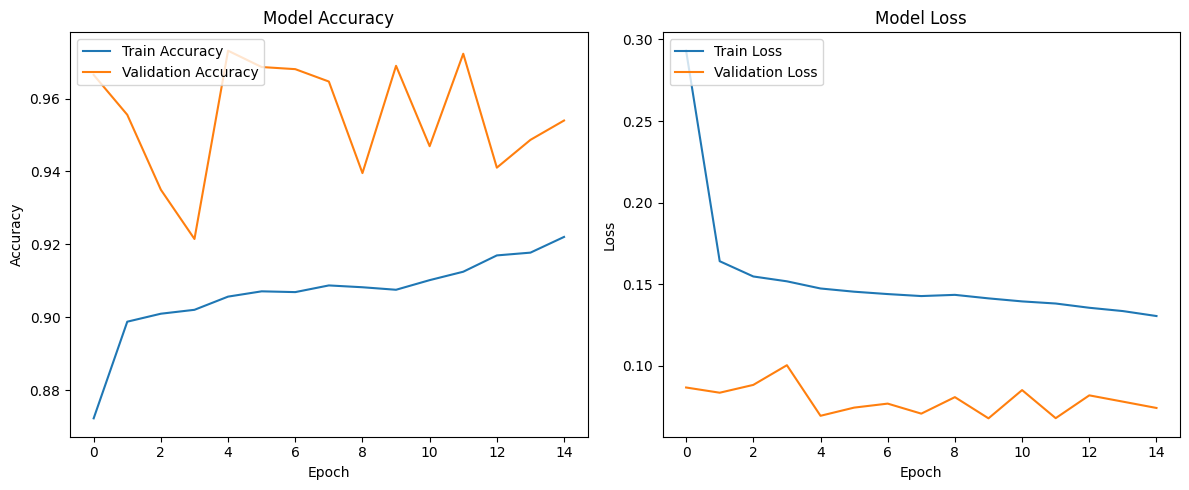

In [ ]:
# Đánh giá mô hình trên tập test
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Loss: {loss}')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')

# Tạo figure và chia làm 2 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Vẽ biểu đồ Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Vẽ biểu đồ Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

# Hiển thị cả hai biểu đồ cùng lúc
plt.tight_layout()
plt.show()

# Thử nghiệm

Model GRU

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


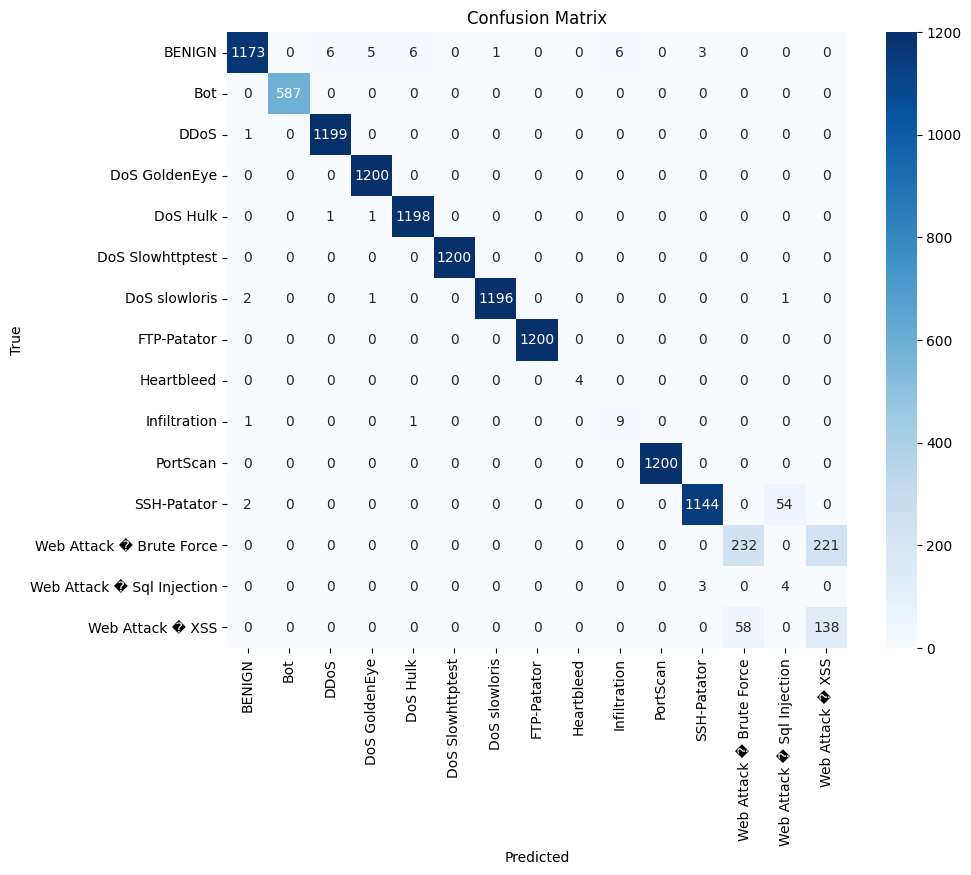

In [ ]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)  # model là mô hình của bạn, đảm bảo đã huấn luyện trước đó
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển đổi dự đoán thành lớp (class)

# Chuyển y_test về dạng số nguyên
y_test_classes = np.argmax(y_test, axis=1)

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Model LSTM

377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


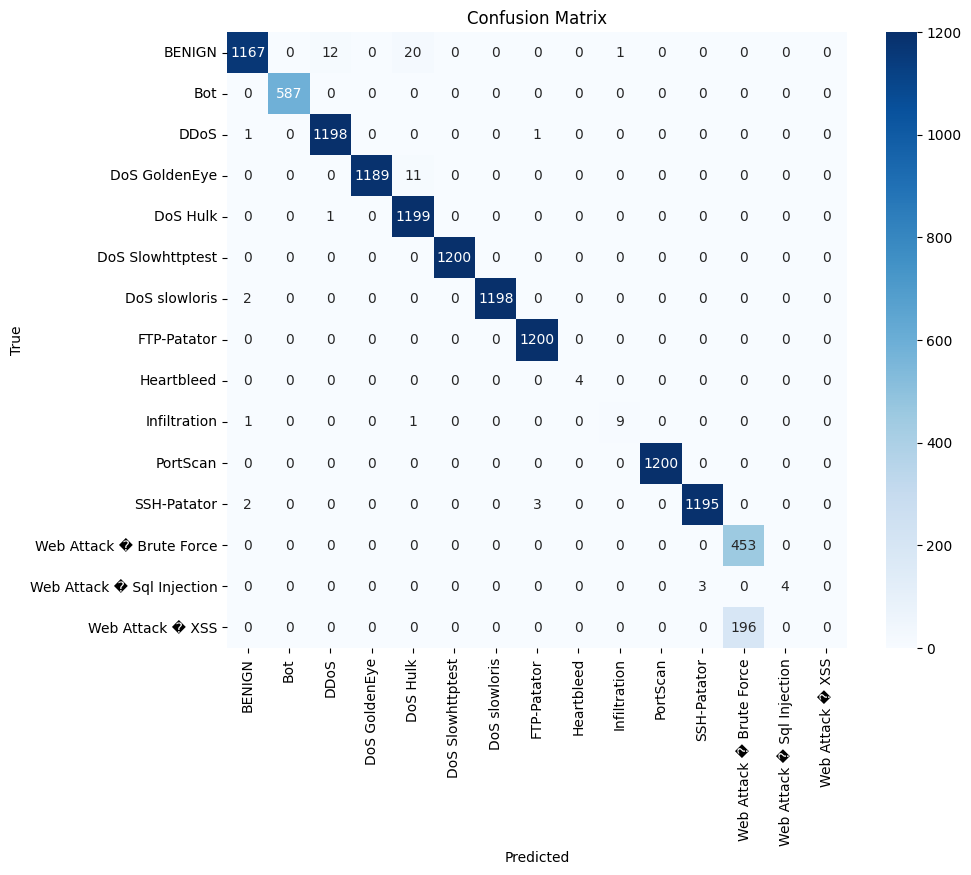

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập test
y_pred = model_lstm.predict(X_test)  # model là mô hình của bạn, đảm bảo đã huấn luyện trước đó
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển đổi dự đoán thành lớp (class)

# Chuyển y_test về dạng số nguyên
y_test_classes = np.argmax(y_test, axis=1)

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()